# Fairness in complex network analysis


In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import pickle
import partition_igraph
from sklearn.metrics import adjusted_mutual_info_score as AMI
import random 
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from abcd_graph import ABCDGraph, ABCDParams
import sknetwork as skn
from sknetwork.classification import get_accuracy_score
import statsmodels.api as sm
from statsmodels.genmod import families

## we use those for the book, but you can change to other colors
cls_edges = 'gainsboro'
cls = ['white','gray','dimgray','black']


In [2]:
def build_ABCD(n=10000, gamma=2.5, delta=5, Delta=50, beta=1.5, s=100, S=8000, 
               xi=0.65, seed=321, num_outliers=0):
    zeta = np.log(Delta) / np.log(n)
    tau = np.log(S) / np.log(n)
    np.random.seed(seed)
    random.seed(seed)
    params = ABCDParams(vcount=n, gamma=gamma, min_degree=delta, max_degree=Delta, beta=beta, 
                        min_community_size=s, max_community_size=S, xi=xi, num_outliers=num_outliers)
    g = ABCDGraph(params).build()
    G = g.exporter.to_igraph()
    return G


In [3]:
def apply_GNN(G, test_prop = 0.5, seed=12, verbose=True):
    labels = np.array(G.vs['ground_truth_community'], dtype='int')
    G_A = G.get_adjacency_sparse()
    nc = np.max(G.vs['ground_truth_community'])+1    
    np.random.seed(seed)
    train_mask = np.random.random(size=len(labels)) < 0.5 ## mask nodes for training
    labels[train_mask] = -1 ## the negative labels are ignored in the training
    
    # GNN classifier with a single hidden layer
    hidden_dim = 2*nc
    n_labels = nc ## ground-truth communities 
    gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                        layer_types='Conv',
                        activations='ReLu',
                        verbose=False)
    
    ## for features, we simply use the adjacency matrix
    features = G_A
    
    ## fit the GCN
    Pred = gnn.fit_predict(G_A, features, labels=labels, n_epochs=50, random_state=42)
    
    if verbose:
        ## apply to test set and compute accuracy
        acc = get_accuracy_score(np.array(G.vs['ground_truth_community'])[train_mask], Pred[train_mask])
        print('accuracy on the test set:', acc)

    return Pred, train_mask


# Web developers graph


In [4]:
## setting the path to the datasets
datadir = "../Datasets/"

In [5]:

## read the GitHub edge list as tuples and build undirected graph
## each node index is stored in vertex attribute "id"
df = pd.read_csv(datadir + "GitHubDevelopers/musae_git_edges.csv")
G = ig.Graph.TupleList(
    [tuple(x) for x in df.values], directed=False, vertex_name_attr="id"
)
## read node attributes
G_attr = pd.read_csv(datadir + "GitHubDevelopers/musae_git_target.csv")
## build attribute dictionaries
ML = dict(zip(G_attr.id, G_attr.ml_target))
G.vs["class"] = [ML[i] for i in G.vs["id"]]


In [6]:
## read extra attribute(s) - is feature 1793 present?
import json
with open(datadir + "GitHubDevelopers/musae_git_features.json") as fp:
    features = json.load(fp)
G.vs['X'] = [int(1793 in features[str(i)]) for i in G.vs['id']]


In [7]:
## build degree feature
for v in range(G.vcount()):
    x = np.array([G.vs[i]['class'] for i in G.neighbors(v)])
    G.vs[v]['web'] = sum(x==0)
    G.vs[v]['ml'] = sum(x==1)


In [8]:
## EDA
data = pd.DataFrame({'web':[i for i in G.vs['web']], 'ml':[i for i in G.vs['ml']], 'X':G.vs['X'], 'Y':G.vs['class']})
data.groupby(by='X').mean()


,web,ml,Y
X,,,
0,14.894584,1.241295,0.140467
1,5.762870,6.276719,0.740846


In [9]:
## ACC&DI&SP
def eval_pred(G, data, pred):
    ACC = np.mean(G.vs['class'] == pred)
    DI = np.abs(np.mean(pred[data['X']==1]) - np.mean(pred[data['X']==0]))
    SP = np.sum([np.abs( np.mean( pred[(data['Y']==1-i) & (data['X']==1)]==i ) - np.mean( pred[(data['Y']==1-i) & (data['X']==0)]==i ) ) for i in [0,1] ])/2
    return (ACC, DI, SP)

In [10]:
## model without protected variable X - single threshold
data = pd.DataFrame({'web':[np.log(1+i) for i in G.vs['web']], 'ml':[np.log(1+i) for i in G.vs['ml']],  'X':G.vs['X'], 'Y':G.vs['class']})

X_sm = sm.add_constant(data[['web', 'ml']])
model_sm = sm.GLM(data['Y'], X_sm, family=sm.families.Binomial(link=families.links.Logit()))
results_sm = model_sm.fit()

t = np.arange(0,1,.01)
accs = [np.mean(G.vs['class'] == (results_sm.predict() >= i)) for i in t]
idx = np.argmax(accs)
pred = (results_sm.predict() > t[idx])

eval_pred(G, data, pred)


(0.8450663129973475, 0.6523662718077865, 0.48035404317175834)

In [11]:
## model with protected variable X - single threshold
X_sm = sm.add_constant(data[['web', 'ml','X']])
model_sm = sm.GLM(data['Y'], X_sm, family=sm.families.Binomial(link=families.links.Logit()))
results_sm = model_sm.fit()

accs = [np.mean(G.vs['class'] == (results_sm.predict() >= i)) for i in t]
idx = np.argmax(accs)
pred = (results_sm.predict() >= t[idx])

eval_pred(G, data, pred)


(0.8509283819628647, 0.8274349458887437, 0.6996912535897551)

### Now with separate thresholds

In [12]:
%%time
## model with protected variable X 
X_sm = sm.add_constant(data[['web', 'ml','X']])
model_sm = sm.GLM(data['Y'], X_sm, family=sm.families.Binomial(link=families.links.Logit()))
results_sm = model_sm.fit()

## one-time work - 
M_acc = np.zeros(shape=(100,100))
M_di = np.zeros(shape=(100,100))
M_sp = np.zeros(shape=(100,100))
_pred = results_sm.predict()
for i in np.arange(0,100):
    for j in np.arange(0,100):
        tau = [i/100,j/100]
        pred = np.array([v >= (tau[1] if c == 1 else tau[0]) for v, c in zip(_pred, G.vs['X'])])
        (acc,di,sp) = eval_pred(G, data, pred)
        M_acc[i,j] = acc
        M_di[i,j] = di
        M_sp[i,j] = sp


CPU times: user 1min 33s, sys: 14.7 ms, total: 1min 33s
Wall time: 1min 25s


In [13]:
def query_results(M_acc, M_di, M_sp, th_di, th_sp):
    mask = ((M_di < th_di) & (M_sp < th_sp))
    _x, _y = np.where(mask)
    acc = M_acc[mask]
    idx = np.argmax(acc)
    return (_x[idx]/100, _y[idx]/100, acc[idx], M_di[mask][idx], M_sp[mask][idx])


In [14]:
## (tau_0, tau_1, accuracy, DI, SP)
print(query_results(M_acc, M_di, M_sp, th_di=1, th_sp=1))
print(query_results(M_acc, M_di, M_sp, th_di=.65, th_sp=1))
print(query_results(M_acc, M_di, M_sp, th_di=.05, th_sp=1))
print(query_results(M_acc, M_di, M_sp, th_di=1, th_sp=.48))
print(query_results(M_acc, M_di, M_sp, th_di=1, th_sp=.05))


(0.38, 0.54, 0.8522811671087533, 0.7988202382274767, 0.6559101656468924)
(0.38, 0.66, 0.8453846153846154, 0.642895363210587, 0.47491052831873604)
(0.38, 0.94, 0.766763925729443, 0.04351690084063709, 0.05436252858651118)
(0.38, 0.66, 0.8453846153846154, 0.642895363210587, 0.47491052831873604)
(0.38, 0.89, 0.7875066312997347, 0.1680946606028314, 0.04158033928245606)


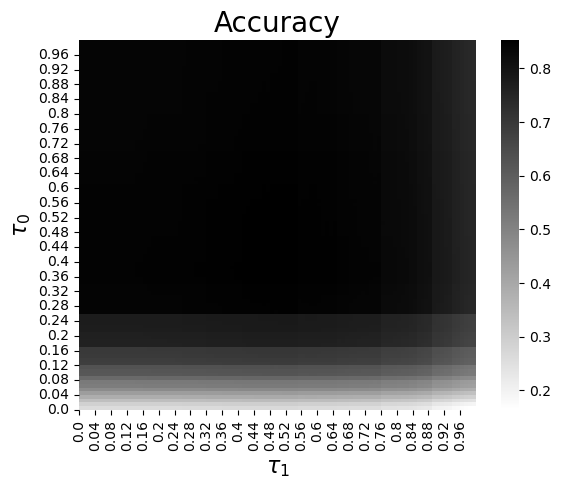

In [15]:
ax = sns.heatmap(M_acc, cmap='gray_r')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(0,1,.04))
ax.set_yticks(np.arange(0,100,4),np.arange(0,1,.04))
plt.title('Accuracy', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


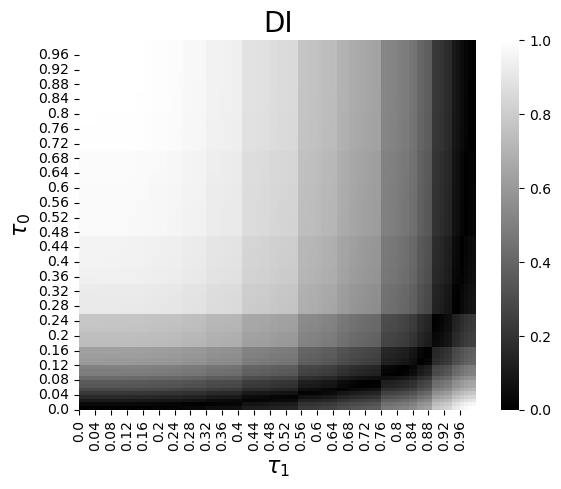

In [16]:
ax = sns.heatmap(M_di, cmap='gray')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(0,1,.04))
ax.set_yticks(np.arange(0,100,4),np.arange(0,1,.04))
plt.title('DI', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


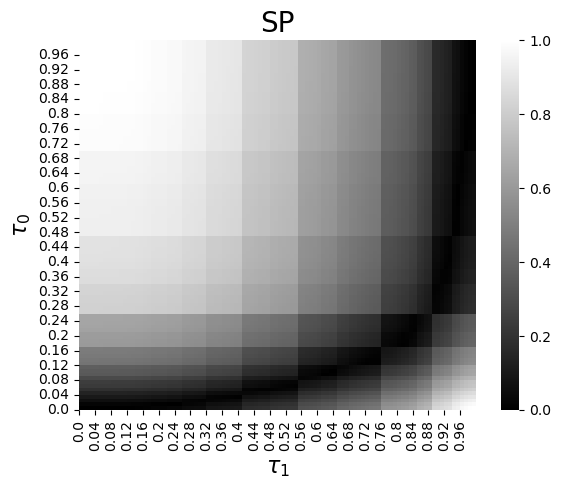

In [17]:
ax = sns.heatmap(M_sp, cmap='gray')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(0,1,.04))
ax.set_yticks(np.arange(0,100,4),np.arange(0,1,.04))
plt.title('SP', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


# Community membership vs degree

* Y = member of a large community
* Xa = degree
* Xb = some protected attribute, correlated with degree
* Prediction is a simple threshold on Xa
* Show bias in predicting Y w.r.t. Xb
* Alleviate the bias with separate threshold on Xa w.r.t. Xb
* Optimize w.r.t. accuracy

#### Details

One large community (1,000) and 10 small ones (100), Y = member of the large community

Degree range [30, 130)

Protected attribute negatively correlated with degree

(1) grid search for optimal cutoff value yields: 
tau=106, accuracy=0.73, DI=0.602, SP=0.144

(2) grid search over (tau0, tau1) with constraints DI<=.2, SP<=.05 yieds:
tau0=116, tau1=102, accuracy=0.66, DI=0.149, SP=0.035

NB: tau1 when attribute is True, so lower degrees, thus the lower cutoff.


In [18]:
## tau: 2-tuple with the two thresholds resp. when attribute is False or True
## _df: dataframe with all relevant data
def compute_accuracy(_df, tau):
    thresh = [tau[i] for i in _df['attribute']]
    _df['pred'] = _df['deg']>thresh
    return sum(_df['pred']==_df['gt'])/_df.shape[0]


In [19]:
## _df: dataframe with all relevant data
def compute_fairness(_df):
    if sum(_df[_df['attribute']==False]['pred'])>0: ## beware of division by zero
        DI = np.abs( ((sum(_df[_df['attribute']==True]['pred'])/len(_df[_df['attribute']==True]['pred'])) / \
        (sum(_df[_df['attribute']==False]['pred'])/len(_df[_df['attribute']==False]['pred']))) -1)
    else:
        DI=1
    a = _df[ (_df['pred']==0) & (_df['gt']==1) & (_df['attribute']==True) ].shape[0] / \
        _df[ (_df['gt']==1) & (_df['attribute']==True) ].shape[0]
    b = _df[ (_df['pred']==0) & (_df['gt']==1) & (_df['attribute']==False) ].shape[0] / \
        _df[ (_df['gt']==1) & (_df['attribute']==False) ].shape[0]
    c = _df[ (_df['pred']==1) & (_df['gt']==0) & (_df['attribute']==True) ].shape[0] / \
        _df[ (_df['gt']==0) & (_df['attribute']==True) ].shape[0]
    d = _df[ (_df['pred']==1) & (_df['gt']==0) & (_df['attribute']==False) ].shape[0] / \
        _df[ (_df['gt']==0) & (_df['attribute']==False) ].shape[0]
    SP = (abs(a-b)+abs(c-d))/2
    return (DI,SP)


In [20]:
## parameters

# seed = 123
# large_comm = 500
# small_comm = 100
# n_small_comms = 5
# n_total = large_comm + (n_small_comms * small_comm)
# degs = np.repeat(np.arange(50,150),10)
# gap = .25
# xi = .3

seed = 123
large_comm = 1000
small_comm = 100
n_small_comms = 10
n_total = large_comm + (n_small_comms * small_comm)
min_deg = 30
degs = np.repeat(np.arange(min_deg,min_deg+100),20)
gap = .25
xi = .1

## generate graph
c = np.concatenate( (np.array([large_comm]),np.repeat(small_comm,n_small_comms)) )
params = ABCDParams(degree_sequence=degs, community_size_sequence=c, vcount=n_total, xi=xi, num_outliers=0)
np.random.seed(seed)
random.seed(seed)
g = ABCDGraph(params).build()
G = g.exporter.to_igraph()

## build dataframe
_df = pd.DataFrame()
_df['gt'] = (np.array(G.vs['ground_truth_community'])==0)
_df['deg'] = G.degree()

## add correlated attribute - lower degrees when True
nodes = np.argsort(G.degree()) ## node from low to high degree
proba = np.linspace(.5+gap,.5-gap,n_total)
attribute = np.random.random(n_total) < proba
G.vs[nodes]['attr']  = attribute
_df['attribute'] = G.vs['attr']

_df.head()


,gt,deg,attribute
0,True,88,False
1,True,113,False
2,True,128,False
3,True,80,False
4,True,124,False


In [21]:
best = 0
best_tau = -1
for d in np.arange(min_deg,min_deg+100):
    a = compute_accuracy(_df, (d,d))
    if a>best:
        best=a
        best_tau = d
a = compute_accuracy(_df, (best_tau,best_tau))
(di,sp) = compute_fairness(_df)
print(best_tau, a, min(1,di), sp)


106 0.73 0.6023614411094409 0.14718088875392246


In [22]:
M_acc = np.zeros(shape=(100,100))
M_di = np.zeros(shape=(100,100))
M_sp = np.zeros(shape=(100,100))

best = 0
best_taus = (-1,-1)
for i in np.arange(min_deg, min_deg+100):
    for j in np.arange(min_deg, min_deg+100):
        taus = [i,j]
        a = compute_accuracy(_df, taus)
        (di,sp) = compute_fairness(_df)
        M_acc[i-min_deg,j-min_deg] = a
        M_di[i-min_deg,j-min_deg] = min(1,di)
        M_sp[i-min_deg,j-min_deg] = sp

        if di<.2 and a>best and sp<.05:
            best=a
            best_taus = (i,j)

a = compute_accuracy(_df, best_taus)
(di,sp) = compute_fairness(_df)
print(best_taus, a, min(1,di), sp)


(116, 102) 0.6555 0.1494435449160706 0.03750585290572073


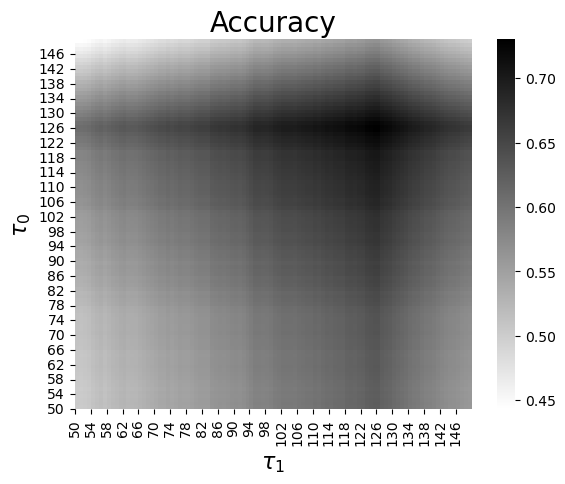

In [23]:
ax = sns.heatmap(M_acc, cmap='gray_r')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(50,150,4))
ax.set_yticks(np.arange(0,100,4),np.arange(50,150,4))
plt.title('Accuracy', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


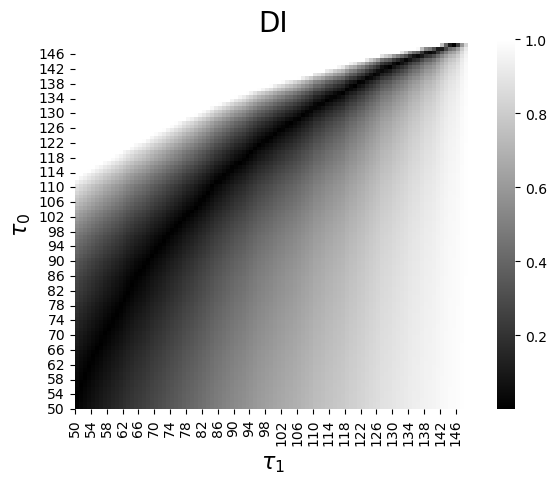

In [24]:
ax = sns.heatmap(M_di, cmap='gray')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(50,150,4))
ax.set_yticks(np.arange(0,100,4),np.arange(50,150,4))
plt.title('DI', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


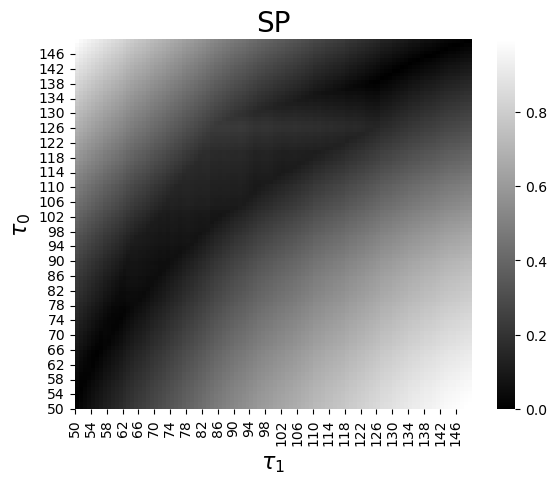

In [25]:
ax = sns.heatmap(M_sp, cmap='gray')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(50,150,4))
ax.set_yticks(np.arange(0,100,4),np.arange(50,150,4))
plt.title('SP', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


## Attribute-based bias experiment

* correlate some attribute (surrogate for gender, race, etc) with degree
* generate ABCD graph
* set target variable Y related to communities 
* perform classification and compute measures DI and SP

**Details:**

* For the attribute variable X, we rank the nodes w.r.t. degree (low to high) ; the ith node has positive attribute value with probability p_i ; p_i varies linearly from 0.5-gap to 0.5+gap. In the experiment, we vary the 'gap' from 0 to 0.5. For each value for the 'gap', we copmpute the correlation with the degrees which we use for the x-axis.

* Choosing the target variable Y to induce bias is not so easy ; it is clear that community misclassification is higher for nodes with low degree, or nodes in smaller communities (which tend to have lower degree), but bias is not so easy to generate for a binary target variable Y based only on communities. Thus we use ABCD+o and introduce outliers, setting Y=1 when the node is an outlier. 

* ABCD parameters: ```G = build_ABCD(n=10000, gamma=2.5, delta=3, Delta=100, beta=1.5, s=100, S=5000, xi=0.5, seed=_seed, num_outliers=3000)```

* For the classifier, we use ECG and compute the CAS score, setting a threshold at 0.4. See details and examples for CAS in Chapter 5.


In [26]:
## community association strength
def cas(G,A):
    deg = np.array(G.degree())
    deg_int = np.array([sum([A[i] == A[j] for i in G.neighbors(j)]) for j in range(G.vcount())])
    Vol = sum(deg)
    Vol_A = np.zeros(max(A)+1, dtype='int')
    for i in range(G.vcount()):
        Vol_A[A[i]] += deg[i]
    return deg_int/deg - (np.array([Vol_A[A[i]] for i in range(G.vcount())]) - deg)/Vol


In [27]:
_seed = 31416 ## 321

## generate ABCD+o
G = build_ABCD(n=10000, gamma=2.5, delta=3, Delta=100, beta=1.5, s=100, S=5000, xi=0.33, 
               seed=_seed, num_outliers=5000)

## set Y=1 for outliers, Y=0 else
comm = G.vs['ground_truth_community']
_tmp = np.array(comm)==-1
G.vs['ground_truth_community'] = [int(i) for i in _tmp]

random.seed(_seed)
np.random.seed(_seed)
_cas = cas(G, G.community_ecg(ens_size=32).membership) < .5
Pred = [int(i) for i in _cas]
Counter(Pred)


Counter({1: 5775, 0: 4225})

In [28]:

L = []

_seed = 31416 ## 321

for _ctr in range(10):
    
    ## generate ABCD+o
    G = build_ABCD(n=10000, gamma=2.5, delta=5, Delta=100, beta=1.5, s=100, S=5000, xi=0.4, ## better results with 0.5 but high misclassification rates, and with delta=3
                   seed=_seed, num_outliers=5000)
    
    ## set Y=1 for outliers, Y=0 else
    comm = G.vs['ground_truth_community']
    _tmp = np.array(comm)==-1
    G.vs['ground_truth_community'] = [int(i) for i in _tmp]
    
    ## binary valued attribute correlated with degree
    nodes = np.argsort(G.degree()) ## node from low to high degree

    random.seed(_seed)
    np.random.seed(_seed)
    _cas = cas(G, G.community_ecg(ens_size=32).membership) < .4
    Pred = [int(i) for i in _cas]
    
    ## vary the gap from 0 to .5
    for gap in np.linspace(0,.5,11):
        proba = np.linspace(.5-gap,.5+gap,10000)
        attribute = np.random.random(10000) < proba
        G.vs[nodes]['attr']  = attribute
        corr = np.corrcoef(G.degree(),G.vs['attr'])[0,1]
        _df = pd.DataFrame()
        _df['gt'] = G.vs['ground_truth_community']
        _df['pred'] = Pred
        _df['misclassified'] = np.array (Pred) != np.array(G.vs['ground_truth_community'])
        _df['degree'] = G.degree()
        _df['attribute'] = G.vs['attr']
        DI = (sum(_df[_df.attribute==True].pred) / len(_df[_df.attribute==True].pred)) / \
        (sum(_df[_df.attribute==False].pred) / len(_df[_df.attribute==False].pred))
        mis_true = sum(_df[_df.attribute==True].misclassified)/len(_df[_df.attribute==True].misclassified)
        mis_false = sum(_df[_df.attribute==False].misclassified)/len(_df[_df.attribute==False].misclassified)
        a = _df[ (_df['pred']==0) & (_df['gt']==1) & (_df['attribute']==True) ].shape[0] / _df[ (_df['gt']==1) & (_df['attribute']==True) ].shape[0]
        b = _df[ (_df['pred']==0) & (_df['gt']==1) & (_df['attribute']==False) ].shape[0] / _df[ (_df['gt']==1) & (_df['attribute']==False) ].shape[0]
        c = _df[ (_df['pred']==1) & (_df['gt']==0) & (_df['attribute']==True) ].shape[0] / _df[ (_df['gt']==0) & (_df['attribute']==True) ].shape[0]
        d = _df[ (_df['pred']==1) & (_df['gt']==0) & (_df['attribute']==False) ].shape[0] / _df[ (_df['gt']==0) & (_df['attribute']==False) ].shape[0]
        SP = (abs(a-b)+abs(c-d))/2
        L.append([gap,corr,DI, SP, mis_true, mis_false])

    _seed += 17

df = pd.DataFrame(L, columns=['gap','correlation','DI', 'SP', 'mis_true','mis_false'])
df.head()


,gap,correlation,DI,SP,mis_true,mis_false
0,0.00,-0.000927,1.006652,0.006467,0.384412,0.391681
1,0.05,0.038051,1.028348,0.014512,0.383633,0.392585
2,0.10,0.075168,1.025831,0.018255,0.386775,0.389381
3,0.15,0.116017,1.022481,0.023494,0.375226,0.400835
4,0.20,0.154902,1.083490,0.051637,0.377583,0.398752


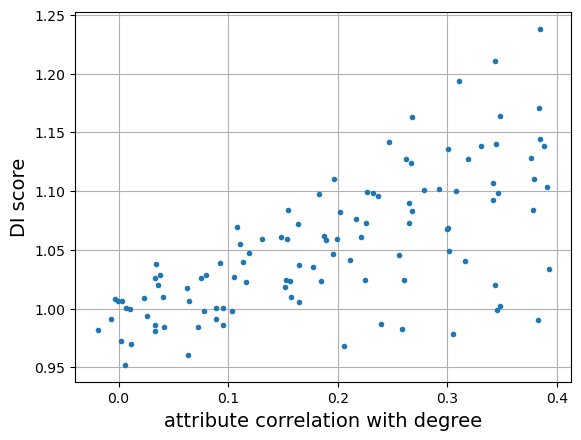

In [29]:
plt.plot(df.correlation, df.DI, '.')
plt.xlabel('attribute correlation with degree', fontsize=14)
plt.ylabel('DI score', fontsize=14)
plt.grid()
plt.show()


In [30]:
np.corrcoef(df.correlation, df.DI)[0,1]

0.6735014558055362

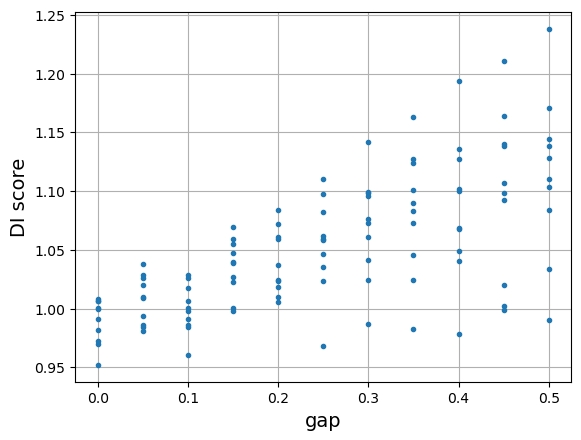

In [31]:
plt.plot(df.gap, df.DI, '.')
plt.xlabel('gap', fontsize=14)
plt.ylabel('DI score' , fontsize=14)
plt.grid()
plt.show()


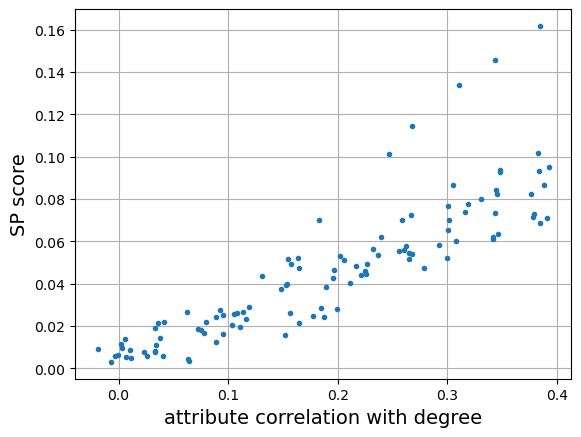

In [32]:
plt.plot(df.correlation, df.SP, '.')
plt.xlabel('attribute correlation with degree', fontsize=14)
plt.ylabel('SP score', fontsize=14)
plt.grid()
plt.show()


In [33]:
np.corrcoef(df.correlation, df.SP)[0,1]

0.8690060761723483

In [34]:
df.mean()

gap            0.250000
correlation    0.190555
DI             1.052167
SP             0.046346
mis_true       0.250363
mis_false      0.279967
dtype: float64